# 实验名称：基于PaddleOCR的车牌识别模型
# 实验简介：
   车牌识别(Vehicle License Plate Recognition，VLPR) 是计算机视频图像识别技术在车辆牌照识别中的一种应用。车牌识别技术要求能够将运动中的汽车牌照从复杂背景中提取并识别出来，在高速公路车辆管理，停车场管理和城市交通中得到广泛应用。
   本次实验我们使用PP-OCRv3这一开源超轻量OCR系统进行车牌识别系统的开发。示例中采用了CCPD数据集,在aistudio中进行训练、推理，实操部分则使用我们自己采集到的小车数据集，在windows环境下训练。

# 实验目的：
   掌握OCR工具进行车牌识别的基本流程。
   

# 示例 - 实验过程：
  ## 步骤一：环境搭建
  实验所需的环境如下：
>PaddlePaddle: 2.3   
>paddleslim: 2.2.2   
>PaddleOCR: Release/2.5

下载PaddleOCR代码

In [ ]:
! git clone -b dygraph https://gitee.com/paddlepaddle/PaddleOCR

In [ ]:
#安装依赖库
! pip install -r PaddleOCR/requirements.txt
! pip install paddleslim editdistance

## 步骤二：数据集准备
所使用的数据集为 CCPD新能源车牌数据集，该数据集分布如下：

>数据集类型	 数量  
>训练集     5769  
>验证集     1001  
>测试集     5006  

数据集可以从这里下载 https://aistudio.baidu.com/aistudio/datasetdetail/101595
下载好数据集后对数据集进行解压

In [ ]:
! unzip -d /home/aistudio/data /home/aistudio/data/data101595/CCPD2020.zip

#### CCPD数据集标注规则如下：
例如: 025-95_113-154&383_386&473-386&473_177&454_154&383_363&402-0_0_22_27_27_33_16-37-15.jpg

每个名称可以分为七个字段，以-符号作为分割。这些字段解释如下。

>025：车牌面积与整个图片区域的面积比。025 (25%)

>95_113：水平倾斜程度和垂直倾斜度。水平 95度 垂直 113度

>154&383_386&473：左上和右下顶点的坐标。左上(154,383) 右下(386,473)

>386&473_177&454_154&383_363&402：整个图像中车牌的四个顶点的精确（x，y）坐标。这些坐标从右下角顶点开始。(386,473) (177,454) (154,383) (363,402)

>0_0_22_27_27_33_16：CCPD中的每个图像只有一个车牌。每个车牌号码由一个汉字，一个字母和五个字母或数字组成。有效的中文车牌由七个字符组成：省（1个字符），字母（1个字符），字母+数字（5个字符）。“ 0_0_22_27_27_33_16”是每个字符的索引。这三个数组定义如下。每个数组的最后一个字符是字母O，而不是数字0。我们将O用作“无字符”的符号，因为中文车牌字符中没有O。因此以上车牌拼起来即为 皖AY339S

>37：牌照区域的亮度。 37 (37%)

>15：车牌区域的模糊度。15 (15%)

#### 制作符合PP-OCR训练格式的标注文件:
在开始训练之前，可使用如下代码制作符合PP-OCR训练格式的标注文件。

In [ ]:
import cv2
import os
import json
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂", "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']

def make_label(img_dir, save_gt_folder, phase):
    crop_img_save_dir = os.path.join(save_gt_folder, phase, 'crop_imgs')
    os.makedirs(crop_img_save_dir, exist_ok=True)
    
    f_det = open(os.path.join(save_gt_folder, phase, 'det.txt'), 'w', encoding='utf-8')
    f_rec = open(os.path.join(save_gt_folder, phase, 'rec.txt'), 'w', encoding='utf-8')
    
    for filename in tqdm(os.listdir(os.path.join(img_dir, phase))):
        str_list = filename.split('-')
        coord_list = str_list[3].split('_')
        txt_list = str_list[4].split('_')
        boxes = []
        for coord in coord_list:
            boxes.append([int(x) for x in coord.split("&")])
        boxes = [boxes[2], boxes[3], boxes[0], boxes[1]]
        lp_number = provinces[int(txt_list[0])] + alphabets[int(txt_list[1])] + ''.join([ads[int(x)] for x in txt_list[2:]])

        # det
        det_info = [{'points':boxes, 'transcription':lp_number}]
        f_det.write('{}\t{}\n'.format(os.path.join(phase, filename), json.dumps(det_info, ensure_ascii=False)))

        # rec
        boxes = np.float32(boxes)
        img = cv2.imread(os.path.join(img_dir, phase, filename))
        # crop_img = img[int(boxes[:,1].min()):int(boxes[:,1].max()),int(boxes[:,0].min()):int(boxes[:,0].max())]
        crop_img = get_rotate_crop_image(img, boxes)
        crop_img_save_filename = '{}.jpg'.format('_'.join(txt_list))
        crop_img_save_path = os.path.join(crop_img_save_dir, crop_img_save_filename)
        cv2.imwrite(crop_img_save_path, crop_img)
        f_rec.write('{}/crop_imgs/{}\t{}\n'.format(phase, crop_img_save_filename, lp_number))
    f_det.close()
    f_rec.close()

def get_rotate_crop_image(img, points):
    '''
    img_height, img_width = img.shape[0:2]
    left = int(np.min(points[:, 0]))
    right = int(np.max(points[:, 0]))
    top = int(np.min(points[:, 1]))
    bottom = int(np.max(points[:, 1]))
    img_crop = img[top:bottom, left:right, :].copy()
    points[:, 0] = points[:, 0] - left
    points[:, 1] = points[:, 1] - top
    '''
    assert len(points) == 4, "shape of points must be 4*2"
    img_crop_width = int(
        max(
            np.linalg.norm(points[0] - points[1]),
            np.linalg.norm(points[2] - points[3])))
    img_crop_height = int(
        max(
            np.linalg.norm(points[0] - points[3]),
            np.linalg.norm(points[1] - points[2])))
    pts_std = np.float32([[0, 0], [img_crop_width, 0],
                          [img_crop_width, img_crop_height],
                          [0, img_crop_height]])
    M = cv2.getPerspectiveTransform(points, pts_std)
    dst_img = cv2.warpPerspective(
        img,
        M, (img_crop_width, img_crop_height),
        borderMode=cv2.BORDER_REPLICATE,
        flags=cv2.INTER_CUBIC)
    dst_img_height, dst_img_width = dst_img.shape[0:2]
    if dst_img_height * 1.0 / dst_img_width >= 1.5:
        dst_img = np.rot90(dst_img)
    return dst_img

def show_ppocr_det_label(img_dir, label_path):
    i = 0
    print('{0} show det {0}'.format('*'*10))
    with open(label_path,'r',encoding='utf-8') as f:
        for line in f.readlines():
            # parse
            line = line.strip().split('\t')
            img_path = os.path.join(img_dir, line[0])
            label_list = json.loads(line[1])
            print(line[0],label_list)
            # show
            img = cv2.imread(img_path)
            for label in label_list:
                cv2.polylines(img, [np.array(label['points'])], True, color=(0, 0, 255), thickness=2)
            plt.figure(figsize=(10, 8))
            plt.imshow(img[:,:,::-1])
            plt.show()
            i+=1
            if i > 3:
                break

def show_ppocr_rec_label(img_dir, label_path):
    i = 0
    print('{0} show rec {0}'.format('*'*10))
    with open(label_path,'r',encoding='utf-8') as f:
        for line in f.readlines():
            # parse
            line = line.strip().split('\t')
            img_path = os.path.join(img_dir, line[0])
            label = line[1]
            print(line[0],label)
            # show
            img = cv2.imread(img_path)
            plt.figure(figsize=(10, 8))
            plt.imshow(img[:,:,::-1])
            plt.show()
            i+=1
            if i > 3:
                break

img_dir = '/home/aistudio/data/CCPD2020/ccpd_green'
save_gt_folder = '/home/aistudio/data/CCPD2020/PPOCR'
# phase = 'train' # change to val and test to make val dataset and test dataset
for phase in ['train','val','test']:
    make_label(img_dir, save_gt_folder, phase)
show_ppocr_det_label(img_dir, os.path.join(save_gt_folder, 'train', 'det.txt'))
show_ppocr_rec_label(save_gt_folder, os.path.join(save_gt_folder, 'train', 'rec.txt'))

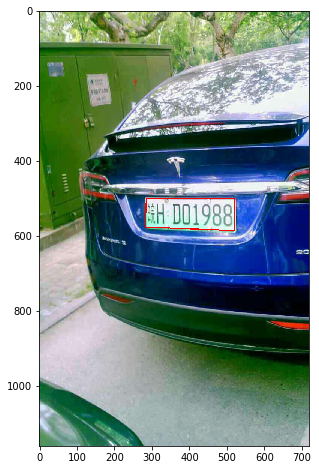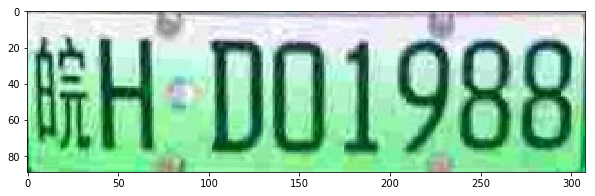

>类型	数据集	              图片地址	                        标签地址	                  图片数量

>检测	训练集	/home/aistudio/data/CCPD2020/ccpd_green/train	/home/aistudio/data/CCPD2020/PPOCR/train/det.txt	    5769

>检测	验证集	/home/aistudio/data/CCPD2020/ccpd_green/val	/home/aistudio/data/CCPD2020/PPOCR/val/det.txt	         1001

>检测	测试集	/home/aistudio/data/CCPD2020/ccpd_green/test	/home/aistudio/data/CCPD2020/PPOCR/test/det.txt	       5006

>识别	训练集	/home/aistudio/data/CCPD2020/PPOCR/train/crop_imgs	/home/aistudio/data/CCPD2020/PPOCR/train/rec.txt	 5769

>识别	验证集	/home/aistudio/data/CCPD2020/PPOCR/val/crop_imgs	/home/aistudio/data/CCPD2020/PPOCR/val/rec.txt	    1001

>识别	测试集	/home/aistudio/data/CCPD2020/PPOCR/test/crop_imgs	/home/aistudio/data/CCPD2020/PPOCR/test/rec.txt   	5006

在普遍的深度学习流程中，都是在训练集训练，在验证集选择最优模型后在测试集上进行测试。在本例中，我们省略中间步骤，直接在训练集训练，在测试集选择最优模型，因此我们只使用训练集和测试集。

## 步骤三：车牌识别
为了模型更好和更快的收敛，这里选用 PaddleOCR 中的 PP-OCRv3 模型进行文本检测和识别，并且使用 PP-OCRv3 模型参数作为预训练模型。
本实验中对于车牌检测和识别有如下2种方案：

>1.PP-OCRv3中英文超轻量预训练模型直接预测    
>2.CCPD车牌数据集在PP-OCRv3模型上fine-tune

## 检测
### 方案一 直接预测
下载PP-OCRv3文本检测预训练模型

In [ ]:
! mkdir models
%cd models
! wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_det_distill_train.tar
! tar -xf ch_PP-OCRv3_det_distill_train.tar
%cd /home/aistudio/PaddleOCR

预训练模型下载完成后，我们使用ch_PP-OCRv3_det_student 配置文件进行后续实验，在开始评估之前需要对配置文件中部分字段进行设置，具体如下：
>Global.pretrained_model: 指向PP-OCRv3文本检测预训练模型地址

>Eval.dataset.data_dir：指向验证集图片存放目录

>Eval.dataset.label_file_list：指向验证集标注文件

>Eval.loader.num_workers: 验证集多进程数据读取的进程数，在aistudio中需要设为2

使用如下命令进行PP-OCRv3文本检测预训练模型的评估

In [ ]:
! python tools/eval.py -c configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml -o \
    Global.pretrained_model=models/ch_PP-OCRv3_det_distill_train/student.pdparams \
    Eval.dataset.data_dir=/home/aistudio/data1/CCPD2020/ccpd_green \
    Eval.dataset.label_file_list=[/home/aistudio/data1/CCPD2020/PPOCR/test/det.txt] \
    Eval.loader.num_workers=2

使用预训练模型进行评估，指标如下所示：
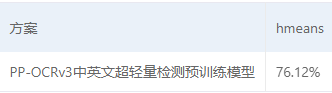

### 方案二 CCPD车牌数据集fine-tune
#### 训练
和评估相同，进行训练也需要对部分字段进行设置，具体如下:

在使用预训练模型进行fine-tune时，需要设置如下11个字段

>Global.pretrained_model: 指向PP-OCRv3文本检测预训练模型地址    

>Global.eval_batch_step: 模型多少step评估一次，这里设为从第0个step开始没隔772个step评估一次，772为一个epoch总的step数。

>Optimizer.lr.name: 学习率衰减器设为常量 Const

>Optimizer.lr.learning_rate: 学习率设为之前的0.05倍

>Optimizer.lr.warmup_epoch: warmup_epoch设为0

>Train.dataset.data_dir：指向训练集图片存放目录

>Train.dataset.label_file_list：指向训练集标注文件

>Train.loader.num_workers: 训练集多进程数据读取的进程数，在aistudio中需要设为1

>Eval.dataset.data_dir：指向验证集图片存放目录

>Eval.dataset.label_file_list：指向验证集标注文件

>Eval.loader.num_workers: 验证集多进程数据读取的进程数，在aistudio中需要设为0

使用如下代码即可启动在CCPD车牌数据集上的fine-tune。

In [ ]:
! python tools/train.py -c configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml -o \
    Global.pretrained_model=models/ch_PP-OCRv3_det_distill_train/student.pdparams \
    Global.save_model_dir=output/CCPD/det/ \
    Global.eval_batch_step="[0, 772]" \
    Optimizer.lr.name=Const \
    Optimizer.lr.learning_rate=0.0005 \
    Optimizer.lr.warmup_epoch=0 \
    Train.dataset.data_dir=/home/aistudio/data/CCPD2020/ccpd_green \
    Train.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/train/det.txt] \
    Train.loader.num_workers=1 \
    Eval.dataset.data_dir=/home/aistudio/data/CCPD2020/ccpd_green \
    Eval.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/test/det.txt] \
    Eval.loader.num_workers=0

#### 评估

训练完成后使用如下命令进行评估

In [ ]:
! python tools/eval.py -c configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml -o \
    Global.checkpoints=output/CCPD/det/best_accuracy.pdparams \
    Eval.dataset.data_dir=/home/aistudio/data/CCPD2020/ccpd_green \
    Eval.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/test/det.txt] \
    Eval.loader.num_workers=2

使用预训练模型和CCPD车牌数据集fine-tune，指标分别如下：
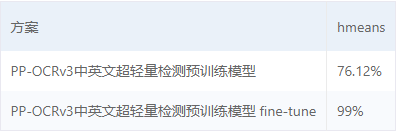
可以看到进行fine-tune能显著提升车牌检测的效果。

####  模型导出
使用如下命令可以将训练好的模型进行导出

In [ ]:
#非量化模型
! python tools/export_model.py -c configs/det/ch_PP-OCRv3/ch_PP-OCRv3_det_student.yml -o \
    Global.pretrained_model=output/CCPD/det/best_accuracy.pdparams \
    Global.save_inference_dir=output/det/infer

## 识别
### 方案一 预训练模型
使用如下命令下载预训练模型

In [ ]:
! mkdir models
%cd models
! wget https://paddleocr.bj.bcebos.com/PP-OCRv3/chinese/ch_PP-OCRv3_rec_train.tar
! tar -xf ch_PP-OCRv3_rec_train.tar
%cd /home/aistudio/PaddleOCR

PaddleOCR提供的PP-OCRv3识别蒸馏预训练模型中包含了多个模型的参数，需要使用如下代码提取Student模型的参数：

In [ ]:
import paddle
# 加载预训练模型
all_params = paddle.load("models/ch_PP-OCRv3_rec_train/best_accuracy.pdparams")
# 查看权重参数的keys
# 学生模型的权重提取
s_params = {key[len("Student."):]: all_params[key] for key in all_params if "Student." in key}
# 查看学生模型权重参数的keys
# 保存
paddle.save(s_params, "models/ch_PP-OCRv3_rec_train/student.pdparams")

预训练模型下载完成后，我们使用ch_PP-OCRv3_rec.yml 配置文件进行后续实验，在开始评估之前需要对配置文件中部分字段进行设置，具体如下：

>Global.pretrained_model: 指向PP-OCRv3文本检测预训练模型地址

>Eval.dataset.data_dir：指向验证集图片存放目录

>Eval.dataset.label_file_list：指向验证集标注文件

>Eval.loader.num_workers: 验证集多进程数据读取的进程数，在aistudio中需要设为2

使用如下命令进行PP-OCRv3文本识别预训练模型的评估

In [ ]:
! python tools/eval.py -c configs/rec/PP-OCRv3/ch_PP-OCRv3_rec.yml -o \
    Global.pretrained_model=models/ch_PP-OCRv3_rec_train/student.pdparams \
    Eval.dataset.data_dir=/home/aistudio/data/CCPD2020/PPOCR \
    Eval.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/test/rec.txt] \
    Eval.loader.num_workers=2

使用预训练模型进行评估，指标如下所示：
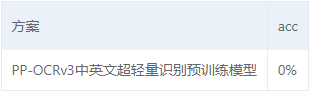
从评估日志中可以看到，直接使用PP-OCRv3预训练模型进行评估，acc非常低，但是norm_edit_dis很高。因此，我们猜测是模型大部分文字识别是对的，只有少部分文字识别错误。使用如下命令进行infer查看模型的推理结果进行验证：

In [ ]:
! python tools/infer_rec.py -c configs/rec/PP-OCRv3/ch_PP-OCRv3_rec.yml -o \
    Global.pretrained_model=models/ch_PP-OCRv3_rec_train/student.pdparams \
    Global.infer_img=/home/aistudio/data/CCPD2020/PPOCR/test/crop_imgs/0_0_24_33_30_31_24_3.jpg

从infer结果可以看到，车牌中的文字大部分都识别正确，只是多识别出了一个·。针对这种情况，有如下两种方案：

>直接通过后处理去掉多识别的·。

>进行 fine-tune 。

 #### 改动后处理
 直接通过后处理去掉多识别的·，在后处理的改动比较简单，只需在 ppocr/postprocess/rec_postprocess.py 文件的76行添加如下代码:

text = text.replace('·','')

改动前后指标对比:
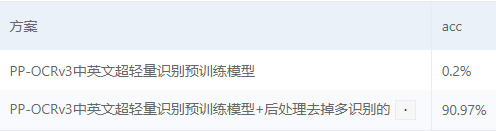
可以看到，去掉多余的·能大幅提高精度。

### 方案二 CCPD车牌数据集fine-tune
和评估相同，进行训练也需要对部分字段进行设置，具体如下:

>Global.pretrained_model: 指向PP-OCRv3文本识别预训练模型地址

>Global.eval_batch_step: 模型多少step评估一次，这里设为从第0个step开始没隔45个step评估一次，45为一个epoch总的step数。

>Optimizer.lr.name: 学习率衰减器设为常量 Const

>Optimizer.lr.learning_rate: 学习率设为之前的0.05倍

>Optimizer.lr.warmup_epoch: warmup_epoch设为0

>Train.dataset.data_dir：指向训练集图片存放目录

>Train.dataset.label_file_list：指向训练集标注文件

>Train.loader.num_workers: 训练集多进程数据读取的进程数，在aistudio中需要设为1

>Train.loader.batch_size_per_card: 训练时每张卡的图片数，这里设为64

>Eval.dataset.data_dir：指向验证集图片存放目录

>Eval.dataset.label_file_list：指向验证集标注文件

>Eval.loader.num_workers: 验证集多进程数据读取的进程数，在aistudio中需要设为0

>Eval.loader.batch_size_per_card: 验证时每张卡的图片数，这里设为64

使用如下命令启动 fine-tune

In [ ]:
! python tools/train.py -c configs/rec/PP-OCRv3/ch_PP-OCRv3_rec.yml -o \
    Global.pretrained_model=models/ch_PP-OCRv3_rec_train/student.pdparams \
    Global.save_model_dir=output/CCPD/rec/ \
    Global.eval_batch_step="[0, 90]" \
    Optimizer.lr.name=Const \
    Optimizer.lr.learning_rate=0.0005 \
    Optimizer.lr.warmup_epoch=0 \
    Train.dataset.data_dir=/home/aistudio/data/CCPD2020/PPOCR \
    Train.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/train/rec.txt] \
    Train.loader.num_workers=1 \
    Train.loader.batch_size_per_card=64 \
    Eval.dataset.data_dir=/home/aistudio/data/CCPD2020/PPOCR \
    Eval.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/test/rec.txt] \
    Eval.loader.num_workers=0 \
    Eval.loader.batch_size_per_card=64

进行fine_tune时，在大约4epoch时指标达到最高

#### 评估

训练完成后使用如下命令进行评估

In [ ]:
! python tools/eval.py -c configs/rec/PP-OCRv3/ch_PP-OCRv3_rec.yml -o \
    Global.pretrained_model=output/CCPD/rec/best_accuracy.pdparams \
    Eval.dataset.data_dir=/home/aistudio/data/CCPD2020/PPOCR \
    Eval.dataset.label_file_list=[/home/aistudio/data/CCPD2020/PPOCR/test/rec.txt] \
    Eval.loader.num_workers=2

使用预训练模型和CCPD车牌数据集fine-tune，指标分别如下：
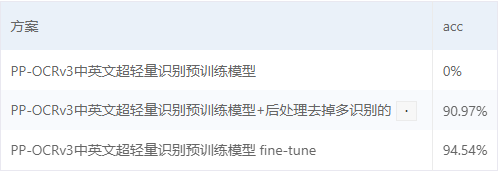
可以看到进行fine-tune能显著提升车牌识别的效果。

#### 模型导出
使用如下命令可以将训练好的模型进行导出。

In [ ]:
#非量化模型
! python tools/export_model.py -c configs/rec/PP-OCRv3/ch_PP-OCRv3_rec.yml -o \
    Global.pretrained_model=output/CCPD/rec/best_accuracy.pdparams \
    Global.save_inference_dir=output/CCPD/rec/infer

## 串联推理
检测模型和识别模型分别fine-tune并导出为inference模型之后，可以使用如下命令进行端到端推理并对结果进行可视化。

In [ ]:
! python tools/infer/predict_system.py \
    --det_model_dir=output/CCPD_pretrain/det/infer/ \
    --rec_model_dir=output/CCPD_pretrain/rec/infer/ \
    --image_dir="/home/aistudio/data/CCPD2020/ccpd_green/test/04131106321839081-92_258-159&509_530&611-527&611_172&599_159&509_530&525-0_0_3_32_30_31_30_30-109-106.jpg" \
    --rec_image_shape=3,48,320

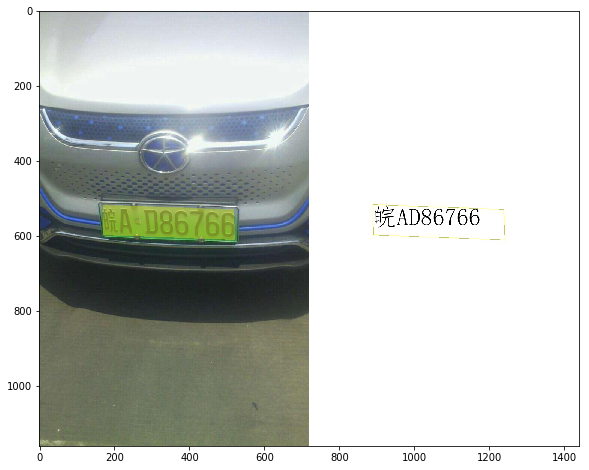

##  计算End2End指标
端到端指标可通过 PaddleOCR内置脚本 进行计算，具体步骤如下：
1. 导出模型（已完成）
2. 用导出的模型对测试集进行预测

此处，分别使用PP-OCRv3预训练模型和fintune模型对测试集的所有图像进行预测，命令如下：

In [ ]:
# PP-OCRv3中英文超轻量检测预训练模型，PP-OCRv3中英文超轻量识别预训练模型
! python3 tools/infer/predict_system.py --det_model_dir=models/ch_PP-OCRv3_det_distill_train/infer --rec_model_dir=models/ch_PP-OCRv3_rec_train/infer --det_limit_side_len=736 --det_limit_type=min --image_dir=/home/aistudio/data/CCPD2020/ccpd_green/test/ --draw_img_save_dir=infer/pretrain --use_dilation=true

# PP-OCRv3中英文超轻量检测预训练模型+fine-tune，PP-OCRv3中英文超轻量识别预训练模型+fine-tune
! python3 tools/infer/predict_system.py --det_model_dir=output/CCPD/det/infer --rec_model_dir=output/CCPD/rec/infer --det_limit_side_len=736 --det_limit_type=min --image_dir=/home/aistudio/data/CCPD2020/ccpd_green/test/ --draw_img_save_dir=infer/fine-tune --use_dilation=true


3. 转换label并计算指标

将gt和上一步保存的预测结果转换为端对端评测需要的数据格式，并根据转换后的数据进行端到端指标计算

In [ ]:
! python3 tools/end2end/convert_ppocr_label.py --mode=gt --label_path=/home/aistudio/data/CCPD2020/PPOCR/test/det.txt --save_folder=end2end/gt

# PP-OCRv3中英文超轻量检测预训练模型，PP-OCRv3中英文超轻量识别预训练模型 结果转换和评估
! python3 tools/end2end/convert_ppocr_label.py --mode=pred --label_path=infer/pretrain/system_results.txt --save_folder=end2end/pretrain
! python3 tools/end2end/eval_end2end.py end2end/gt end2end/pretrain

# PP-OCRv3中英文超轻量检测预训练模型fine-tune，PP-OCRv3中英文超轻量识别预训练模型fine-tune 结果转换和评估
! python3 tools/end2end/convert_ppocr_label.py --mode=pred --label_path=infer/fine-tune/system_results.txt --save_folder=end2end/fine-tune
! python3 tools/end2end/eval_end2end.py end2end/gt end2end/fine-tune

在之前的预测结果中，可以看到很多不符合车牌标注的文字被识别出来, 因此可以进行简单的过滤来提升precision

为了快速评估，我们在 tools/end2end/convert_ppocr_label.py 脚本的 58 行加入如下代码，对非8个字符的结果进行过滤

In [ ]:
if len(txt) != 8: # 车牌字符串长度为8
    continue

各个方案端到端指标如下：
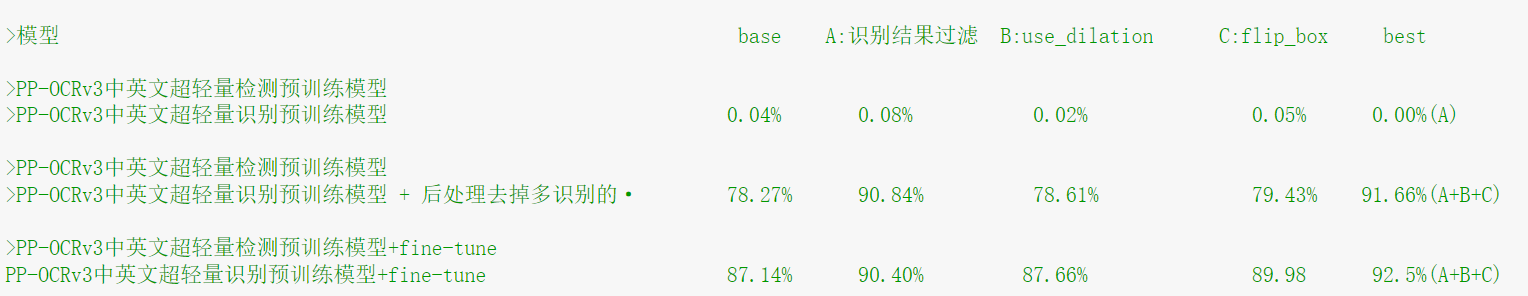
从结果中可以看到对预训练模型不做修改，只根据场景下的具体情况进行后处理的修改就能大幅提升端到端指标到91.66%，在CCPD数据集上进行 fine-tune 后指标进一步提升到92.5%

## 实验结论
>PP-OCRv3的检测模型在未经过fine-tune的情况下，在车牌数据集上也有一定的精度，经过 fine-tune 后能够极大的提升检测效果，精度达到99%。

>PP-OCRv3的识别模型在未经过fine-tune的情况下，在车牌数据集上精度为0，但是经过分析可以知道，模型大部分字符都预测正确，但是会多预测一个特殊字符，去掉这个特殊字符后，精度达到90%。PP-OCRv3识别模型在经过 fine-tune 后识别精度进一步提升，达到94.4%。

>从端到端结果中可以看到对预训练模型不做修改，只根据场景下的具体情况进行后处理的修改就能大幅提升端到端指标到91.66%，在CCPD数据集上进行 fine-tune 后指标进一步提升到92.5%。

# 实操 - 实验过程：
接下来我们采用自己采集到的小车车牌数据集进行车牌识别实验。实验过程与以上流程完全相同，只是需要我们自己制作数据集并导入。
## 步骤一：环境搭建
参考示例实验
## 步骤二：数据集准备
### 图像采集
首先，我们需要获得一组数量合适的小车车牌照片。为增强模型的鲁棒性，建议在不同光照、不同背景、不同文字干扰的环境下采集数据集。
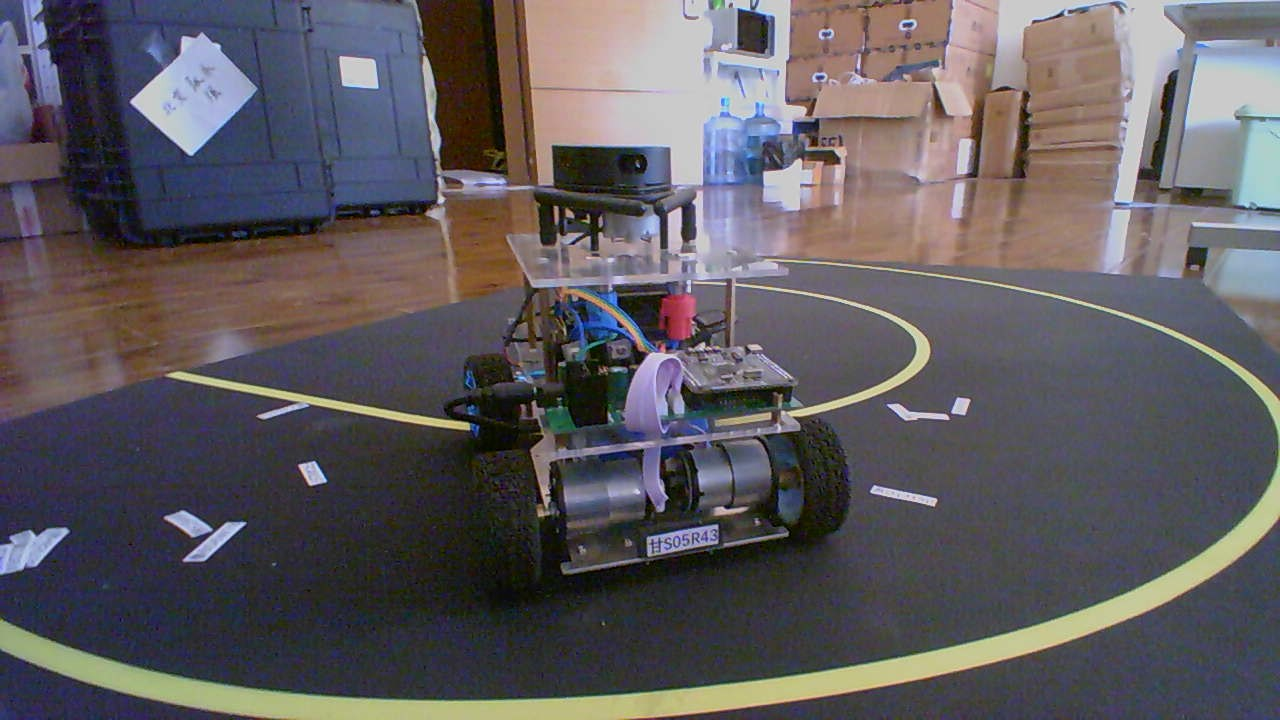


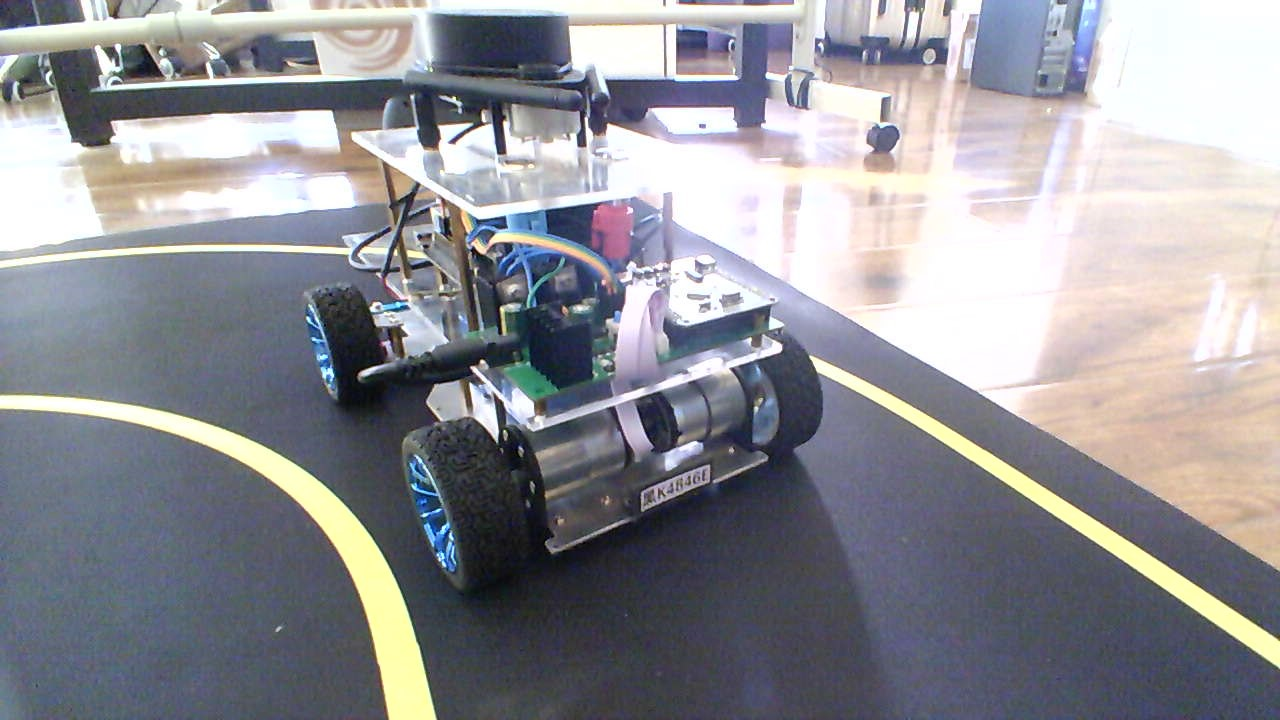

### 图像标注
#### PPOCRLabel安装
采集好数据集后，我们使用PPOCRLabel这一官方数据集标注工具，来直接获得满足PaddleOCR训练所需的格式的数据集。Windows环境下，使用如下命令进行PPOCRLabel工具的安装。

In [ ]:
pip install PPOCRLabel  # 安装
PPOCRLabel --lang ch  # 启动【普通模式】，用于打【检测+识别】场景的标签

#### PPOCRLabel使用

>打开文件夹：在菜单栏点击 “文件” - "打开目录" 选择待标记图片的文件夹[1].

>自动标注：点击 ”自动标注“，使用PP-OCR超轻量模型对图片文件名前图片状态[2]为 “X” 的图片进行自动标注。自动标注后，检查标注结果，对未标出及错标的文字进行手动标注。

>手动标注：点击 “矩形标注”（推荐直接在英文模式下点击键盘中的 “W”)，对当前图片中模型未检出的部分进行手动绘制标记框。点击键盘Q，则使用四点标注模式（或点击“编辑” - “四点标注”），用户依次点击4个点后，双击左键表示标注完成。

>标记框绘制完成后，用户点击 “确认”，检测框会先被预分配一个 “待识别” 标签。

>重新识别：将图片中的所有检测画绘制/调整完成后，点击 “重新识别”，PP-OCR模型会对当前图片中的所有检测框重新识别[3]。

>内容更改：单击识别结果，对不准确的识别结果进行手动更改。

>确认标记：点击 “确认”，图片状态切换为 “√”，跳转至下一张。

>删除：点击 “删除图像”，图片将会被删除至回收站。

>导出结果：用户可以通过菜单中“文件-导出标记结果”手动导出，同时也可以点击“文件 - 自动导出标记结果”开启自动导出。手动确认过的标记将会被存放在所打开图片文件夹下的Label.txt中。在菜单栏点击 “文件” - "导出识别结果"后，会将此类图片的识别训练数据保存在crop_img文件夹下，识别标签保存在rec_gt.txt中[4]。

#### 注意
[1] PPOCRLabel以文件夹为基本标记单位，打开待标记的图片文件夹后，不会在窗口栏中显示图片，而是在点击 "选择文件夹" 之后直接将文件夹下的图片导入到程序中。

[2] 图片状态表示本张图片用户是否手动保存过，未手动保存过即为 “X”，手动保存过为 “√”。点击 “自动标注”按钮后，PPOCRLabel不会对状态为 “√” 的图片重新标注。

[3] 点击“重新识别”后，模型会对图片中的识别结果进行覆盖。因此如果在此之前手动更改过识别结果，有可能在重新识别后产生变动。

[4] PPOCRLabel产生的文件放置于标记图片文件夹下，包括一下几种，请勿手动更改其中内容，否则会引起程序出现异常。

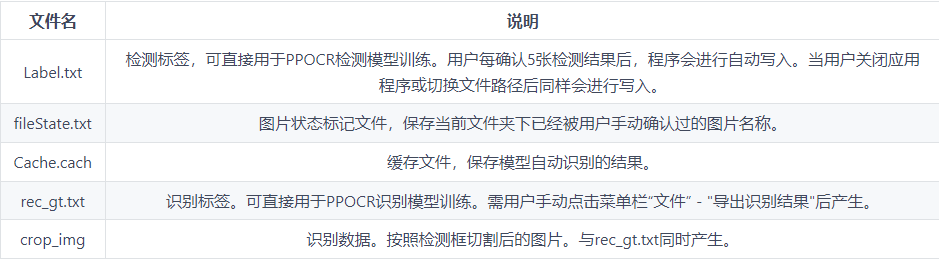

#### 数据集划分
在终端中输入以下命令执行数据集划分脚本：

In [ ]:
cd ./PPOCRLabel # 将目录切换到PPOCRLabel文件夹下
python gen_ocr_train_val_test.py --trainValTestRatio 6:2:2 --datasetRootPath ./xiaoche 

参数说明：

trainValTestRatio 是训练集、验证集、测试集的图像数量划分比例，根据实际情况设定，默认是6:2:2

datasetRootPath 是PPOCRLabel标注的完整数据集存放路径。默认路径是 PPOCRLabel/xiaoche 分割数据集前应有如下结构：

In [ ]:
|-xiaoche
  |-crop_img
    |- word_001_crop_0.png
    |- word_002_crop_0.jpg
    |- word_003_crop_0.jpg
    | ...
  | Label.txt
  | rec_gt.txt
  |- word_001.png
  |- word_002.jpg
  |- word_003.jpg
  | ...

## 车牌识别
同示例实验。

## 串联推理
使用训练获得的模型进行效果可视化。

[2022/09/09 15:26:29] ppocr INFO: In PP-OCRv3, rec_image_shape parameter defaults to '3, 48, 320', if you are using recognition model with PP-OCRv2 or an older version, please set --rec_image_shape='3,32,320
[2022/09/09 15:26:31] ppocr DEBUG: dt_boxes num : 1, elapse : 1.8462276458740234
[2022/09/09 15:26:31] ppocr DEBUG: rec_res num  : 1, elapse : 0.024933338165283203
[2022/09/09 15:26:31] ppocr DEBUG: 0  Predict time of D:/Code/PaddleOCR-release-2.5/data/xiaoche/WIN_20220822_18_18_57_Pro.jpg: 1.877s
[2022/09/09 15:26:31] ppocr DEBUG: 川A7QL48, 0.956
[2022/09/09 15:26:31] ppocr DEBUG: The visualized image saved in ./inference_results\WIN_20220822_18_18_57_Pro.jpg
[2022/09/09 15:26:31] ppocr INFO: The predict total time is 1.981865406036377


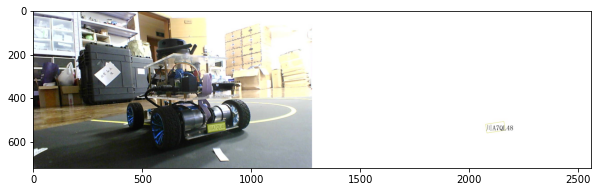

In [7]:
! python tools/infer/predict_system.py \
    --det_model_dir=output/xiaoche_det/infer/ \
    --rec_model_dir=output/xiaoche_rec/infer/ \
    --image_dir="D:/Code/PaddleOCR-release-2.5/data/xiaoche/WIN_20220822_18_18_57_Pro.jpg" \
    --rec_image_shape=3,48,320
from matplotlib import pyplot as plt
# show img
plt.figure(figsize=(10, 8))
img = plt.imread("./inference_results/WIN_20220822_18_18_57_Pro.jpg")
plt.imshow(img)

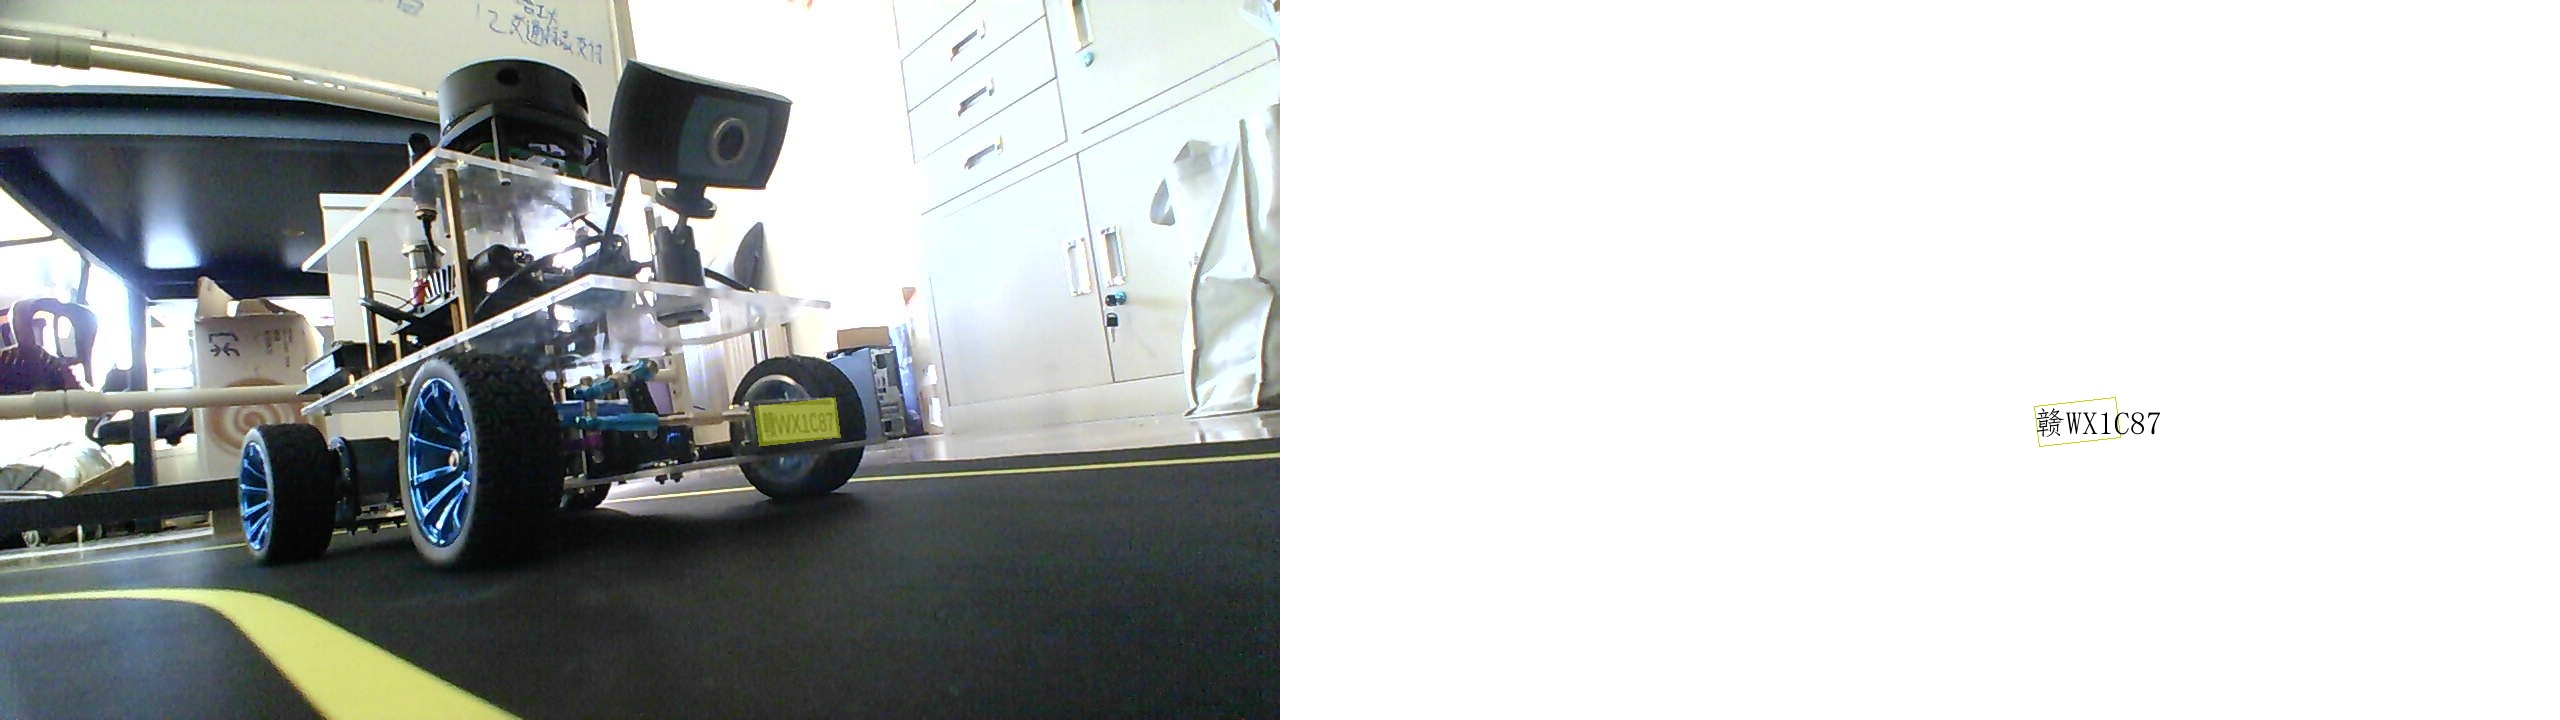